In [1]:
import numpy as np # linear algebra
import sklearn as skl # machine learning models + preprocessing
import pandas as pd # data visualization
from matplotlib import pyplot as plt # plotting

In [2]:
# Load the data
X_train = np.loadtxt('data/X_train.csv', delimiter=',') # training data (features)
X_test = np.loadtxt('data/X_test.csv', delimiter=',') # testing data (features)
y_train = np.genfromtxt('data/y_train.csv', dtype=str) # training labels

def save_prediction(y_path, y_pred):
    df = pd.DataFrame({"Prediction": y_pred})
    df.index += 1
    df.index.name = "ID"
    df.to_csv(y_path)

In [3]:
# Visualization code
from matplotlib.colors import ListedColormap

def plot_decision_boundaries(X, y, best_clf):
    def plot_decision_regions(X, y, classifier, xlab="", ylab="", title="", resolution=0.02):
        plt.figure(figsize=(8, 6))
        # setup marker generator and color map
        markers = ('s', 'x', 'o', '^', 'v')
        colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
        cmap = ListedColormap(colors[:len(np.unique(y))])

        # plot the decision surface
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        for idx, cl in enumerate(np.unique(y)):
            plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                        alpha=0.8, c=cmap(idx),
                        marker=markers[idx], label=cl)
        plt.title(title)
        plt.legend()
        plt.show()
    
    m = {'Iris-versicolor': 0, 'Iris-virginica': 1, 'Iris-setosa': 2}
    y = np.asarray(list(map(lambda x: m[x], y)))
    clf = skl.base.clone(best_clf, safe=True)
    features = X.shape[1]
    features_d = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
    for i in range(features):
        for j in range(i+1, features):
            X_new = X[:, [i, j]]
            clf.fit(X_new, y)
            xlab = features_d[i]
            ylab = features_d[j]
            plot_decision_regions(X_new, y, clf, xlab=xlab, ylab=ylab,
                                  title='Trained on features: {} and {}'.format(xlab, ylab))

def plot_param(results, param_key):
    plt.figure()
    plt.title("CV plot")
    plt.xlabel(param_key)
    plt.ylabel("Accuracy")
    plt.grid()
    train_sizes = list(map(lambda x: x[param_key], results['params']))
    test_scores_mean = results['mean_test_score']
    test_scores_std = results['std_test_score']
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="CV mean test score")
    plt.show()

def plot_runs_box(results, ylim=None):
    plt.figure()
    plt.title("CV box plot")
    plt.xlabel("Run")
    plt.ylabel("Accuracy")
    if ylim is not None:
        plt.gca().set_ylim(ylim)
    train_sizes = [i for i in range(len(results['params']))]
    cv_folds = 0
    while True:
        prop_name = 'split' + str(cv_folds) + "_test_score"
        if prop_name not in results:
            break
        cv_folds += 1
    plt.xticks(train_sizes)
    run_scores = np.zeros((cv_folds, len(train_sizes)))
    for i in range(cv_folds):
        row = results['split' + str(i) + "_test_score"]
        for j, element in enumerate(row):
            run_scores[i, j] = element
    plt.boxplot(run_scores, showmeans=True)
    plt.show()
    print("CV folds:", cv_folds)
    
def print_runs(results):
    for i, run in enumerate(results['params']):
        print("Run", i+1, "\t", run)

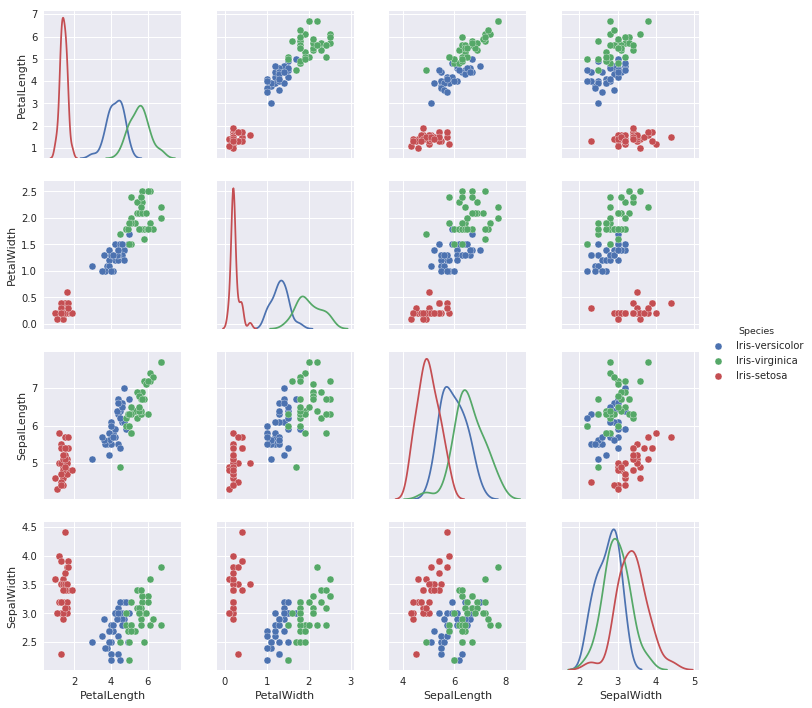

In [4]:
# Data visualization
import seaborn as sns
sns.set()

# Scatter plots for the features
def scatterplot_matrix(iris):
    sns.pairplot(iris, hue='Species', diag_kind='kde', hue_order=['Iris-versicolor', 'Iris-virginica', 'Iris-setosa'])
    plt.show()

iris = pd.DataFrame({'SepalLength': list(X_train[:, 0]),
                     'SepalWidth': list(X_train[:, 1]),
                     'PetalLength': list(X_train[:, 2]),
                     'PetalWidth': list(X_train[:, 3]),
                     'Species': list(y_train)})
scatterplot_matrix(iris)

In [5]:
# Cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline([
#     ('SVC', SVC(kernel='linear', C=1.0))
    ('KNN', KNeighborsClassifier(n_neighbors=80))
])

param_grid = {
#     'SVC__C': [1.0]
    'KNN__n_neighbors': [80]
}

cv = min(int(np.sqrt(len(X_train))), 10)
gridsearch = GridSearchCV(pipeline, cv=cv, param_grid=param_grid, verbose=1)
gridsearch.fit(X_train, y_train)

best = pipeline
best.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Pipeline(memory=None,
     steps=[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=80, p=2,
           weights='uniform'))])

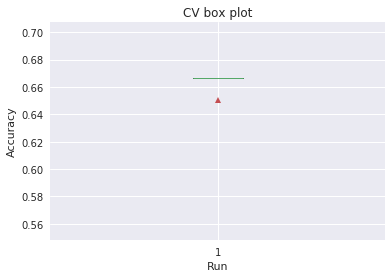

CV folds: 10
Run 1 	 {'KNN__n_neighbors': 80}

Best parameters: {'KNN__n_neighbors': 80}


In [6]:
# Grid Search results
plot_runs_box(gridsearch.cv_results_)
print_runs(gridsearch.cv_results_)
print('\nBest parameters:', gridsearch.best_params_)

Best chosen model (manually): Pipeline(memory=None,
     steps=[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=80, p=2,
           weights='uniform'))])


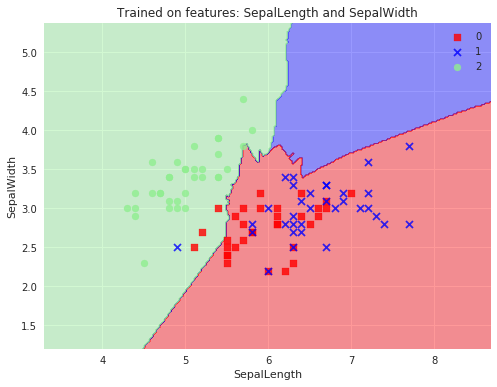

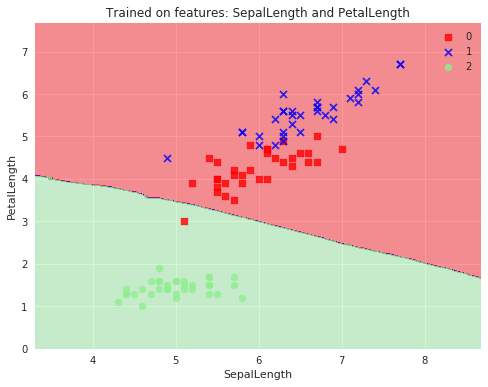

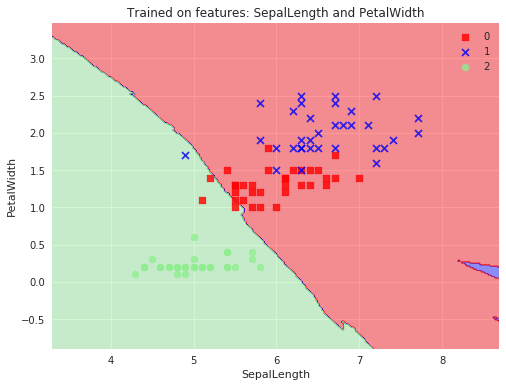

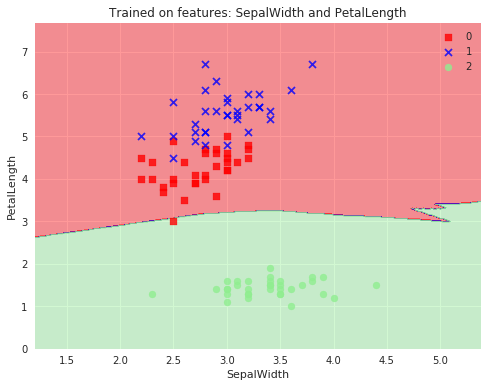

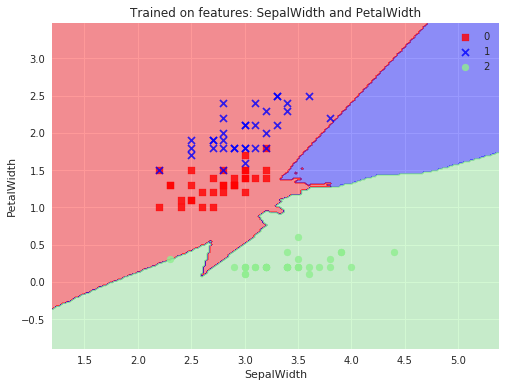

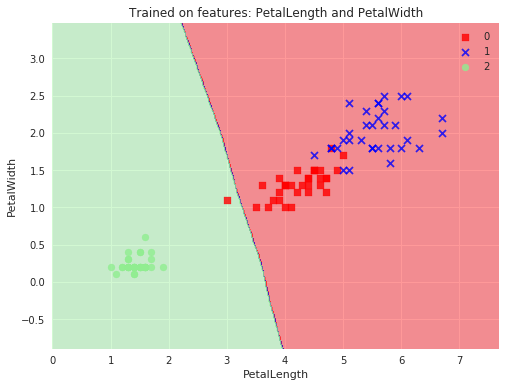

In [7]:
# Best parameters and decision boundaries
print('Best chosen model (manually):', best)
plot_decision_boundaries(X_train, y_train, best)

In [8]:
from datetime import datetime
time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')

y_pred = best.predict(X_test)
np.savetxt('data/predictions/y_pred_{0}.csv'.format(time),  y_pred, fmt='%s')
print('Saved to disk.')
save_prediction('data/predictions/y_pred_{0}_kaggle.csv'.format(time),  y_pred)
print('Saved kaggle file to disk.')

Saved to disk.
Saved kaggle file to disk.


In [9]:
y_pred_train = best.predict(X_train)
print('Train accuracy: ', skl.metrics.accuracy_score(y_pred=y_pred_train, y_true=y_train))

Train accuracy:  0.66
